<h1 align="center"><font face = "Times New Roman" size = "80">H.264 Video Compression</font></h1>
<h2 align="center"><font face = "Times New Roman" size = ""> Information theory and coding</font></h2>
<h3 align="center"><font face = "Times New Roman"> Fall 2019</font></h3>
<h5 align="center"><font face = "Times New Roman"">Alaa Mohamed Roshdy&nbsp 201600031</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Adham Mahrous&nbsp 201601078</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Mostafa Hamed&nbsp 201600236</font></h5>
<h5 align="center"><font face = "Times New Roman">Mohamed Kasem Saber&nbsp 201601144</font></h5>




---



In [1]:
from matplotlib import pyplot as plt
import cv2
from IPython.display import Video # To display the video in the notebook

In [18]:
# View video
vid = cv2.VideoCapture('DNA.mp4')
# Initialize a np array to hold all frames.
vid_frame = []
# Read until video is completed
while(vid.isOpened()):
        # Capture frame-by-frame
        ret, frame = vid.read()
        if ret == True:
 
            # Display the resulting frame
            cv2.imshow('Frame',frame)
            # Convert frame to grayscale
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # Add frame to list of frames
            vid_frame.append(frame)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
 
        # Break the loop
        else: 
            break

# Closes all the frames
cv2.destroyAllWindows()

# Display the video in the noreb
Video("DNA.mp4")

In [7]:
# Display the properties of the video
height = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
width  = vid.get(cv2.CAP_PROP_FRAME_WIDTH) 
print ("Video Dimension: height:{} width:{}".format( height, width))

framecount = vid.get(cv2.CAP_PROP_FRAME_COUNT ) 
frames_per_sec = vid.get(cv2.CAP_PROP_FPS)
print("Video duration (sec):", framecount / frames_per_sec)
print("Number of frames: ", framecount)
print("FPS: ", frames_per_sec)

Video Dimension: height:720.0 width:1280.0
Video duration (sec): 6.666666666666667
Number of frames:  200.0
FPS:  30.0


(720, 1280)

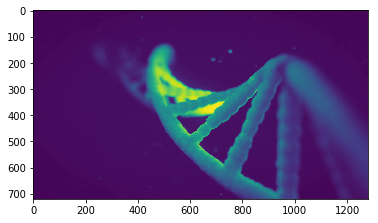

In [19]:
plt.imshow(vid_frame[100])
vid_frame[100].shape

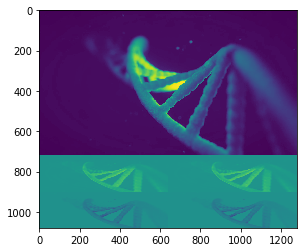

In [16]:
#yuv_im = cv2.cvtColor(vid_frame[100], cv2.COLOR_RGB2YUV_I420)
#plt.imshow(yuv_im)
#fig, (ax1, ax2, ax3) = plt.subplots(1,3)
#ax1.imshow(yuv_im[:,:,0])
#ax2.imshow(yuv_im[:,:,1])
#ax3.imshow(yuv_im[:,:,2])

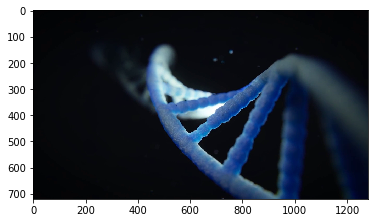

In [17]:
plt.imshow(vid_frame[110])

In [36]:
def reshape_image(image, box_size = 16):

    n_rows = np.int(np.floor(image.shape[0]/box_size))
    n_cols = np.int(np.floor(image.shape[1]/box_size))

    image_array = cv2.resize(vid_frame[100], dsize=(n_rows*box_size, n_cols*box_size))
    return image_array

In [37]:
def get_sub_images(image_array, box_size=16):
    """
    Gets a grayscale image and returns an array of (box_size, box_size) elements
    Args:
        image_array (numpy ndarray): Image input we want to divide to box
                                     sub_images.
         Should have shape (length, width, n_channels) where length = width
          e. g. n_channels = 3 for RGB
         box_size (int): Size of the box sub images
    Returns:
        divided_image (numpy ndarray, dtype = "uint8"): array of divided images
         - should have a shape of (X, box_size, box_size, n_channels).
        n_rows: number of rows or blocks
        n_cols: number of columns in image
          the number of blocks is n_rows*n_cols
    """
    n_rows = np.int(image_array.shape[0]/box_size)
    n_cols = np.int(image_array.shape[1]/box_size)

    # make the image into a square to simplify operations based
    #  on the smaller dimension
    # d = min(n_cols, n_rows)

    # Note: images are converted to uint8 datatypes since they range between
    #  0-255. different datatypes might misbehave (based on my trials)
    image_blocks = np.asarray([np.zeros((box_size, box_size), dtype='uint8')
                               for i in range(n_rows*n_cols)], dtype='uint8')

    # break down the image into blocks
    c = 0
    for i in range(n_rows):
        for j in range(n_cols):
            image_blocks[c] = image_array[i*box_size: i*box_size+box_size,
                                          j*box_size:j*box_size+box_size]
            c += 1

    # If you want to reconvert the output of this function into images,
    #  use the following line:
    # block_image = Image.fromarray(output[idx])

    return image_blocks, n_rows, n_cols

In [38]:
def get_reconstructed_image(divided_image, n_rows, n_cols, box_size=8):
    """
    Gets an array of (box_size,box_size) pixels
    and returns the reconstructed image
    Args:
        divided_image (numpy ndarray, dtype = "uint8"): array of divided images
        n_rows: number of rows or blocks
        n_cols: number of columns in image
            the number of blocks is n_rows*n_cols
        box_size (int): Size of the box sub images
    Returns:
        reconstructed_image (numpy ndarray): Image reconstructed from the array
        of divided images.

    """
    image_reconstructed = np.zeros((n_rows*box_size, n_cols*box_size), dtype=np.uint8)
    c = 0
    # break down the image into blocks
    for i in range(n_rows):
        for j in range(n_cols):
            image_reconstructed[i*box_size: i*box_size+box_size, 
                                j*box_size:j*box_size+box_size] = divided_image[c]
            c += 1
            
    # If you want to reconvert the output of this function into images,
    #  use the following line:
    # block_image = Image.fromarray(output[idx])

    return image_reconstructed


Dimensions of the ref image is  (720, 1280)
Dimensions of the ref divided is (3600, 16, 16)


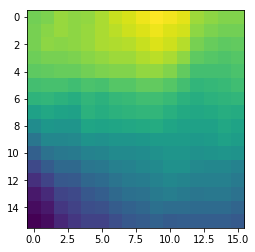

In [46]:
import numpy as np

im_blocks_ref, n_rows, n_cols = get_sub_images(reshape_image(vid_frame[100]))
im_blocks_p, __, __ = get_sub_images(reshape_image(vid_frame[110]))
print('Dimensions of the ref image is ', vid_frame[100].shape)
print('Dimensions of the ref divided is', im_blocks_ref.shape)

#fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
#ax1.imshow(vid_frame[100])
#ax2.imshow(get_reconstructed_image(im_blocks_ref,n_rows,n_cols,16))
#ax3.imshow(Image.fromarray(im_blocks_p[60*30 + 31]))
plt.imshow(im_blocks_ref[2000])

(64, 64)

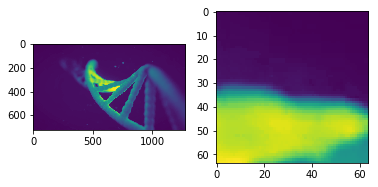

In [55]:
# 496 is the 31th block in terms of 16x16 macroblocks, and 800 is the 50th microblock
search_area = 32
im = vid_frame[100]
im_block = vid_frame[100][(300 - search_area) : (300 + search_area), (650 - search_area) : (650 + search_area)]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im)
ax2.imshow(im_block)
im_block.shape

In [43]:
def rmse(im, reconstructed_image):
    """
    Gets the root mean squared error between 2 images
    Args:
         im (numpy array) : The original image
         reconstructed_image (numpy ndarray): The reconstructed image
    Returns:
        rmse: root mean squared error as a metric to compare between the original image and the reconstructed
    """
    error = im - reconstructed_image
    mse = np.sum(np.square(error)) / (im.shape[0] * im.shape[1])
    rmse = np.sqrt(mse)

    return rmse

Loss =  0.0  for image block 2000
Total time taken to find motion vectors is 0.5512669086456299  * 3600 ((number of microblocks)) = 1984.5608711242676


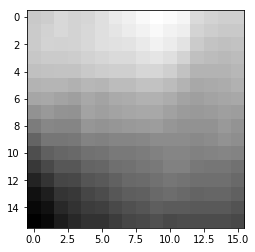

In [44]:
import time
loss_prev = 1000
n = 0
t = time.time()
for i in range(3600):
    loss = rmse(im_blocks_p[2000], im_blocks_ref[i])
    if loss < loss_prev:
        loss_prev = loss
        n = i
t = time.time() - t
print('Loss = ', loss_prev, ' for image block', n)
print("Total time taken to find motion vectors is" ,t, " * 3600 ((number of microblocks)) =", t*3600)
plt.imshow(im_blocks_ref[n], 'gray')

In [56]:
coordinates = (2,3)
y,x = coordinates
y

2